##### **NLP - HW3 - Part2**
##### Student name: **Majid Adibian**
##### Student number: **400131078**

In [1]:
!gdown 11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
!gdown 1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
!gdown 127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU

!pip install --upgrade gensim

Downloading...
From: https://drive.google.com/uc?id=11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
To: /content/dev.conll
100% 478k/478k [00:00<00:00, 89.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
To: /content/test.conll
100% 677k/677k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU
To: /content/train.conll
100% 11.4M/11.4M [00:00<00:00, 54.6MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gensim.downloader as api
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import pickle


main_path = '/content/drive/MyDrive/Colab Notebooks/NLP_HWs/HW3/'

##### Read file and create data and labels sequences

In [3]:
def read_file(path):
    f = open(path, 'r')
    lines = f.readlines()
    vocabs = set()
    labels_set = set()
    all_data = []
    all_labels = []
    data_seq = []
    label_seq = []
    for line in lines:
        if line.strip():
            line_parts = line.split()
            data_seq.append(line_parts[1])
            vocabs.add(line_parts[1])
            if line_parts[2] == '0':
                label = 'Root'
            elif int(line_parts[2]) > int(line_parts[0]):
                label = str(int(line_parts[2])-int(line_parts[0])) + 'R'
            else:
                label = str(int(line_parts[0])-int(line_parts[2])) + 'L'
            label_seq.append(label)
            labels_set.add(label)
        else:
            all_data.append(data_seq)
            all_labels.append(label_seq)
            data_seq = []
            label_seq = []
    tag2id = {tag:i+2 for i, tag in enumerate(list(labels_set))}
    tag2id['PAD'] = 0
    tag2id['OOV'] = 1
    id2tag = {i:tag for tag,i in tag2id.items()}
    return all_data, all_labels, vocabs, tag2id, id2tag

In [4]:
train_data, train_labels, vocabs, tag2id, id2tag = read_file('train.conll')

##### Prepare word embeddings
###### load word2vec from gensim

In [ ]:
wv = api.load('word2vec-google-news-300')

[================================================--] 96.5% 1604.7/1662.8MB downloaded

###### Save embeddings of words in this project

In [5]:
def is_number(str):
    try:
        float(str)
        return True
    except:
        return False

def get_word_embedding(wv, word):
    if word in wv:
        res = wv[word]
    else:
        word = word.replace('"', '').replace("'", '').replace(",", '')
        if word in wv:
            res = wv[word]
        elif word.replace('-', '') in wv:
            res = wv[word.replace('-', '')]
        elif '-' in word and word.split('-')[1] in wv:
            res = wv[word.split('-')[1]]
        elif '-' in word and word.split('-')[0] in wv:
            res = wv[word.split('-')[0]]
        elif is_number(word):
            numbers = [wv[str(i)] for i in range(10)]
            res = sum(numbers)/10
        else:
            res = None
    return res

In [ ]:
word2vec = {}
k = 0
for word in vocabs:
    word_embedding = get_word_embedding(wv, word)
    if type(word_embedding) != type(None):
        word2vec[word] = word_embedding
word2vec['PAD'] = np.zeros(word2vec[list(word2vec)[0]].shape)
word2vec['OOV'] = np.ones(word2vec[list(word2vec)[0]].shape)

In [ ]:
f = open(main_path + 'word2vec.pkl', 'wb')
pickle.dump(word2vec, f)
f.close()

###### load word embeddings

In [6]:
f = open(main_path + "word2vec.pkl", "rb")
word2vec = pickle.load(f)
f.close()

##### Convert data and labels to matrixes

In [7]:
def create_matrixes(data, labels, params):
    data_seqs =  []
    label_seqs = []
    for i, seq in enumerate(data):
        for j in range(0, len(seq), params['step_size']):
            local_seq = seq[j:j+params['max_seq_len']]
            local_seq = local_seq + ['PAD' for _ in range(params['max_seq_len'] - len(local_seq))]
            data_seqs.append(local_seq)
            local_label = labels[i][j:j+params['max_seq_len']]
            local_label = local_label + ['PAD' for _ in range(params['max_seq_len'] - len(local_label))]
            label_seqs.append(local_label)
    data_matrix = np.zeros((len(data_seqs), params['max_seq_len'], params['word_embed_size']))
    label_matrix = np.zeros((len(label_seqs), params['max_seq_len']))
    for i in range(data_matrix.shape[0]):
        for j in range(data_matrix.shape[1]):
            word = data_seqs[i][j]
            label = label_seqs[i][j]
            word_embedding = get_word_embedding(params['word2vec'], word)
            if type(word_embedding) != type(None):
                data_matrix[i][j] = word_embedding
            else:
                data_matrix[i][j] = params['word2vec']['OOV']
            if label in params['tag2id']:
                label_matrix[i][j] = params['tag2id'][label]
            else:
                label_matrix[i][j] = params['tag2id']['OOV']
    return data_matrix, label_matrix

In [8]:
params = {'word2vec':word2vec, 'tag2id':tag2id, 'id2tag':id2tag, 'max_seq_len': 10, 'step_size':10, 'word_embed_size':300}
train_data_matrix, train_label_matrix = create_matrixes(train_data, train_labels, params)

##### Prepare validation and test data

In [9]:
val_data, val_labels, _, _, _ = read_file('dev.conll')
val_data_matrix, val_label_matrix = create_matrixes(val_data, val_labels, params)

test_data, test_labels, _, _, _ = read_file('test.conll')
test_data_matrix, test_label_matrix = create_matrixes(test_data, test_labels, params)

##### create model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 256)          439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 10, 156)          40092     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 10, 156)           0         
                                                                 
Total params: 479,388
Trainable params: 479,388
Non-trainable params: 0
_________________________________________________________________


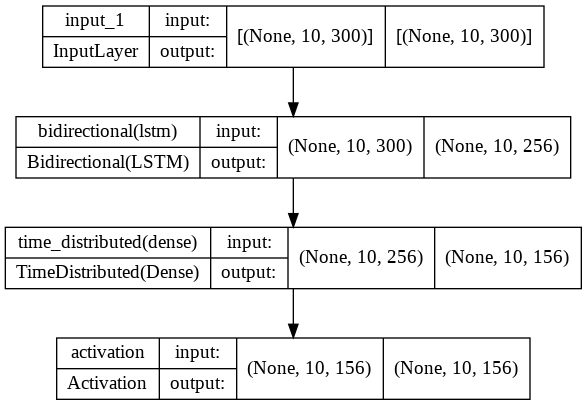

In [10]:
model = Sequential()
model.add(Input(shape=(params['max_seq_len'], params['word_embed_size'])))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(len(params['tag2id']))))
model.add(Activation('softmax'))
 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
history = model.fit(train_data_matrix, train_label_matrix, batch_size=1024, epochs=15, shuffle=True, validation_data=(val_data_matrix, val_label_matrix))
model.save(main_path + "model.h5")
with open(main_path+'history.p', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/15
111/111 [==============================] - 73s 588ms/step - loss: 2.3854 - accuracy: 0.4064 - val_loss: 1.8670 - val_accuracy: 0.5054
Epoch 2/15
111/111 [==============================] - 64s 573ms/step - loss: 1.6124 - accuracy: 0.5789 - val_loss: 1.5260 - val_accuracy: 0.5997
Epoch 3/15
111/111 [==============================] - 62s 561ms/step - loss: 1.3673 - accuracy: 0.6383 - val_loss: 1.3647 - val_accuracy: 0.6353
Epoch 4/15
111/111 [==============================] - 63s 566ms/step - loss: 1.2425 - accuracy: 0.6670 - val_loss: 1.2815 - val_accuracy: 0.6559
Epoch 5/15
111/111 [==============================] - 62s 563ms/step - loss: 1.1768 - accuracy: 0.6816 - val_loss: 1.2317 - val_accuracy: 0.6653
Epoch 6/15
111/111 [==============================] - 78s 701ms/step - loss: 1.1328 - accuracy: 0.6918 - val_loss: 1.2009 - val_accuracy: 0.6719
Epoch 7/15
111/111 [==============================] - 62s 559ms/step - loss: 1.0973 - accuracy: 0.6999 - val_loss: 1.1682 - val_ac

##### Plot loss and accuracy per epoch

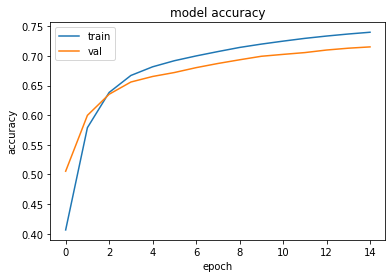

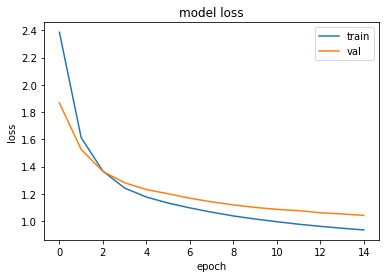

In [12]:
def plot_train_info(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

plot_train_info(main_path+'history.p')

###### Calculate accuracy, recall, precision and f1-score in test data

In [13]:
def evaluate_model(test_input_matrix, test_target_matrix, id2tag, model=None):
    if not model:
        model = models.load_model(main_path + "model.h5")
    all_predicted = model.predict(test_input_matrix)
    pred_tags = []
    real_tags = []
    for i, test_seqs in enumerate(all_predicted):
        for j, pred_tag_vec in enumerate(test_seqs):
            pred_tags.append(np.argmax(pred_tag_vec))
            real_tags.append(test_target_matrix[i][j])
    recall = recall_score(real_tags, pred_tags, average='weighted')
    precision = precision_score(real_tags, pred_tags, average='weighted')
    f1 = f1_score(real_tags, pred_tags, average='weighted')
    accuracy = accuracy_score(real_tags, pred_tags)
    return recall, precision, f1, accuracy

recall, precision, f1, accuracy = evaluate_model(test_data_matrix, test_label_matrix, params['id2tag'])
print('recall: ' + str(recall))
print('precision: ' + str(precision))
print('f1_score: ' + str(f1))
print('accuracy: ' + str(accuracy))

recall: 0.7145392693388553
precision: 0.6763525442681231
f1_score: 0.6908818939762784
accuracy: 0.7145392693388553


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Predict labels of some sentences

In [14]:
def prepare_sample_sentence(sample_sentences, params):
    seqs = []
    for sentence in sample_sentences:
        seq = sentence.split()
        seqs.append(seq)
    sample_data_matrix, _ = create_matrixes(seqs, seqs, params)
    return sample_data_matrix

def get_result(sample_data_matrix, id2tag, model=None):
    if not model:
        model = models.load_model(main_path + "model.h5")
    all_predicted = model.predict(sample_data_matrix)
    pred_tags = [[id2tag[np.argmax(tags_prob)] for tags_prob in test_seq if id2tag[np.argmax(tags_prob)]!='PAD'] for test_seq in all_predicted ]
    return pred_tags

In [22]:
sample_sentences = ['There are no mistakes , only opportunities .',
                    'Simplicity is the ultimate sophistication .',
                    'Whatever you do , do it well .',
                    'This is a test sentence .']

sample_data_matrix = prepare_sample_sentence(sample_sentences, params)
sample_tags = get_result(sample_data_matrix, id2tag, model=None)
for i, tags in enumerate(sample_tags):
    print(sample_sentences[i] + ':')
    print(tags)

There are no mistakes , only opportunities .:
['1R', 'Root', '1R', '2L', '2R', '1R', '3L', '6L']
Simplicity is the ultimate sophistication .:
['4R', '3R', '2R', '1R', 'Root', '1L']
Whatever you do , do it well .:
['2R', '1R', 'Root', '1R', '2L', '1L', '2L', '3L']
This is a test sentence .:
['4R', '3R', '2R', '1R', 'Root', '4L']


### Sumplementary: Using Glove as embedding 

In [56]:
import gensim.downloader as gensim_api

print(gensim_api.load("glove-wiki-gigaword-300", return_path=True))
glove_model = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded
/root/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


In [67]:
glove = {}
k = 0
for word in vocabs:
    word_embedding = get_word_embedding(glove_model, word)
    if type(word_embedding) != type(None):
        glove[word] = word_embedding
glove['PAD'] = np.zeros(glove[list(glove)[0]].shape)
glove['OOV'] = np.ones(glove[list(glove)[0]].shape)

###### Save glove embeddings for our words

In [69]:
f = open(main_path + 'glove.pkl', 'wb')
pickle.dump(glove, f)
f.close()

In [ ]:
f = open(main_path + "glove.pkl", "rb")
glove = pickle.load(f)
f.close()

###### Create matrixes to train the model

In [70]:
params2 = {'word2vec':glove, 'tag2id':tag2id, 'id2tag':id2tag, 'max_seq_len': 10, 'step_size':10, 'word_embed_size':300}
train_data_matrix2, train_label_matrix2 = create_matrixes(train_data, train_labels, params2)

In [71]:
val_data2, val_labels2, _, _, _ = read_file('dev.conll')
val_data_matrix2, val_label_matrix2 = create_matrixes(val_data2, val_labels2, params2)

test_data2, test_labels2, _, _, _ = read_file('test.conll')
test_data_matrix2, test_label_matrix2 = create_matrixes(test_data2, test_labels2, params2)

###### Create model with one additional BiLSTM layer and Dropout

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 10, 256)          439296    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 10, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 156)          20124     
 tributed)                                                       
                                                                 
 activation_5 (Activation)   (None, 10, 156)           0         
                                                      

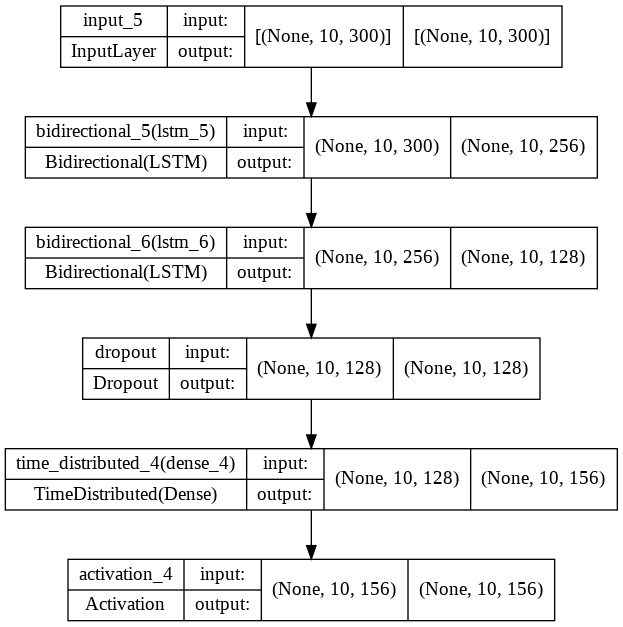

In [74]:
model2 = Sequential()
model2.add(Input(shape=(params['max_seq_len'], params['word_embed_size'])))
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.1))
model2.add(TimeDistributed(Dense(len(params['tag2id']))))
model2.add(Activation('softmax'))
 
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [75]:
history2 = model2.fit(train_data_matrix2, train_label_matrix2, batch_size=1024, epochs=15, shuffle=True, validation_data=(val_data_matrix2, val_label_matrix2))
model2.save(main_path + "model2.h5")
with open(main_path+'history2.p', 'wb') as f:
    pickle.dump(history2.history, f)

Epoch 1/15
111/111 [==============================] - 96s 869ms/step - loss: 1.5966 - accuracy: 0.5763 - val_loss: 1.3017 - val_accuracy: 0.6409
Epoch 2/15
111/111 [==============================] - 92s 828ms/step - loss: 1.2154 - accuracy: 0.6642 - val_loss: 1.1720 - val_accuracy: 0.6786
Epoch 3/15
111/111 [==============================] - 92s 826ms/step - loss: 1.1169 - accuracy: 0.6913 - val_loss: 1.1105 - val_accuracy: 0.6946
Epoch 4/15
111/111 [==============================] - 95s 853ms/step - loss: 1.0569 - accuracy: 0.7080 - val_loss: 1.0727 - val_accuracy: 0.7046
Epoch 5/15
111/111 [==============================] - 96s 863ms/step - loss: 1.0146 - accuracy: 0.7194 - val_loss: 1.0447 - val_accuracy: 0.7109
Epoch 6/15
111/111 [==============================] - 93s 834ms/step - loss: 0.9830 - accuracy: 0.7276 - val_loss: 1.0258 - val_accuracy: 0.7174
Epoch 7/15
111/111 [==============================] - 94s 846ms/step - loss: 0.9571 - accuracy: 0.7347 - val_loss: 1.0095 - val_ac

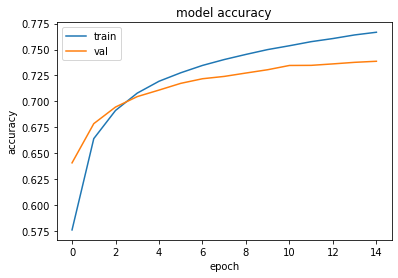

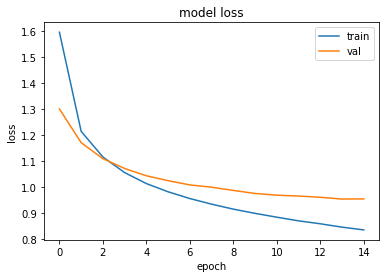

In [78]:
plot_train_info(main_path+'history2.p')

In [77]:
recall2, precision2, f12, accuracy2 = evaluate_model(test_data_matrix2, test_label_matrix2, params['id2tag'])
print('recall: ' + str(recall2))
print('precision: ' + str(precision2))
print('f1_score: ' + str(f12))
print('accuracy: ' + str(accuracy2))

recall: 0.7358970566484248
precision: 0.697726001725157
f1_score: 0.7138065622893378
accuracy: 0.7358970566484248


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
